### Load the Stable Diffusion 2.0 and our pretrained ControlNet model

In [1]:
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDPMScheduler,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
from pipeline_controlnet_inpaint import StableDiffusionControlNetInpaintPipeline

from transformers import AutoTokenizer, PretrainedConfig
import torch

controlnet = ControlNetModel.from_pretrained('./controlnet')
def import_model_class_from_model_name_or_path(pretrained_model_name_or_path: str, revision: str):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "RobertaSeriesModelWithTransformation":
        from diffusers.pipelines.alt_diffusion.modeling_roberta_series import RobertaSeriesModelWithTransformation

        return RobertaSeriesModelWithTransformation
    else:
        raise ValueError(f"{model_class} is not supported.")

        
tokenizer = AutoTokenizer.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        subfolder="tokenizer",
        use_fast=False,
    )

sd_inpainting_model_name = "stabilityai/stable-diffusion-2-inpainting"
# import correct text encoder class
text_encoder_cls = import_model_class_from_model_name_or_path(sd_inpainting_model_name, None)

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(sd_inpainting_model_name, subfolder="scheduler")
text_encoder = text_encoder_cls.from_pretrained(
    sd_inpainting_model_name, subfolder="text_encoder", revision=None
)
vae = AutoencoderKL.from_pretrained(sd_inpainting_model_name, subfolder="vae", revision=None)
unet = UNet2DConditionModel.from_pretrained(
    sd_inpainting_model_name, subfolder="unet", revision=None
)

weight_dtype = torch.float32
pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    sd_inpainting_model_name,
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    controlnet=controlnet,
    safety_checker=None,
    revision=None,
    torch_dtype=weight_dtype,
)
pipeline.scheduler = UniPCMultistepScheduler.from_config(pipeline.scheduler.config)
pipeline = pipeline.to('cuda')
pipeline.set_progress_bar_config(disable=True)

2024-04-15 17:42:14.168263: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 17:42:14.202711: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

### Inference

In [2]:
from PIL import Image, ImageOps
import requests
from io import BytesIO

def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

seed = 0
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Granja_comary_Cisne_-_Escalavrado_e_Dedo_De_Deus_ao_fundo_-Teres%C3%B3polis.jpg/2560px-Granja_comary_Cisne_-_Escalavrado_e_Dedo_De_Deus_ao_fundo_-Teres%C3%B3polis.jpg'
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img = resize_with_padding(img, (512, 512))

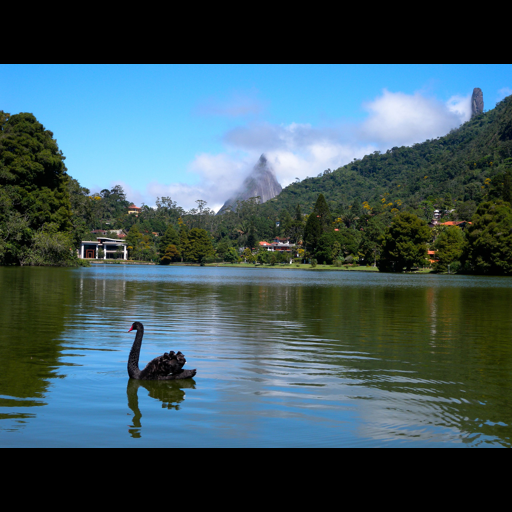

In [3]:
img

/home/erfan/virtualenv/inpainting/lib/python3.8/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3491.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Settings -> Mode=base, Device=cuda:0, Torchscript=disabled
Settings -> Mode=base, Device=cuda:0, Torchscript=disabled


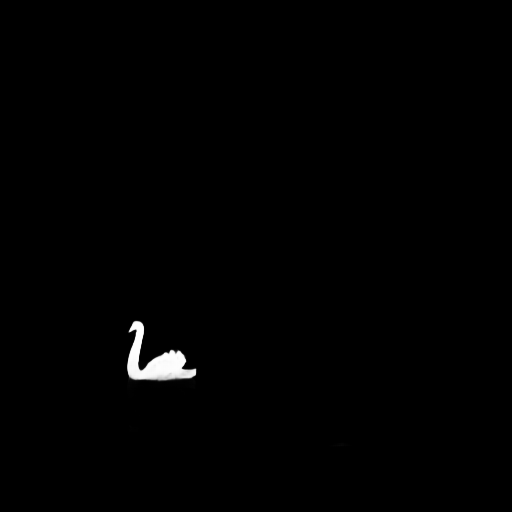

In [4]:
from transparent_background import Remover

# Load model
remover = Remover() # default setting
remover = Remover(mode='base') # nightly release checkpoint
fg_mask = remover.process(img, type='map') # default setting - transparent background
fg_mask

## Background generation using Stable Diffusion without ControlNet (cond_scale=0)

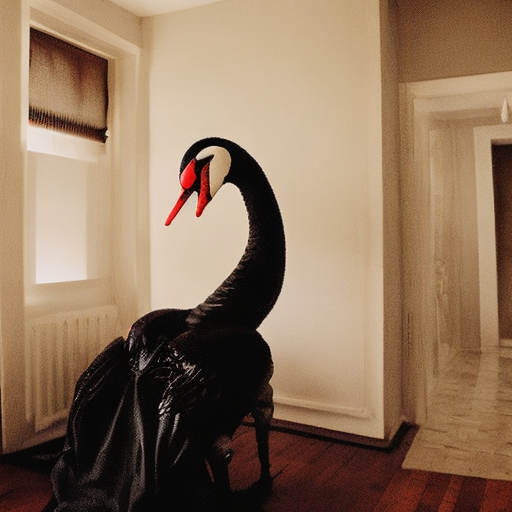

In [5]:
seed = 13
mask = ImageOps.invert(fg_mask)
img = resize_with_padding(img, (512, 512))
generator = torch.Generator(device='cuda').manual_seed(seed)
prompt = 'A dark swan in a bedroom'
cond_scale = 0.0
with torch.autocast("cuda"):
    sd2_image = pipeline(
        prompt=prompt, image=img, mask_image=mask, control_image=mask, num_images_per_prompt=1, generator=generator, num_inference_steps=20, guess_mode=False, controlnet_conditioning_scale=cond_scale
    ).images[0]
sd2_image

Where did our swan go? Looks it's belnded into a bigger swan!

## Stable Diffusion with Controlnet (cond_scale = 1)

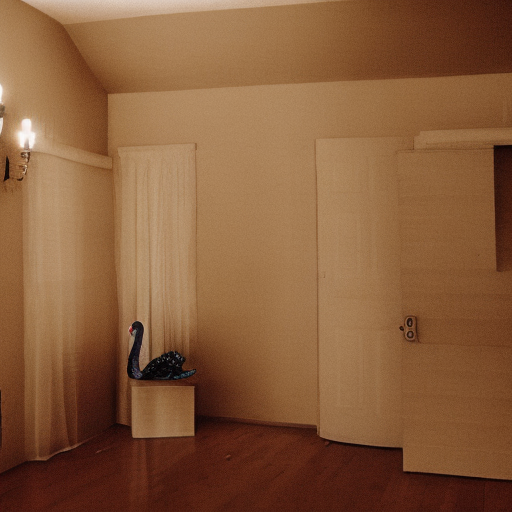

In [6]:
mask = ImageOps.invert(fg_mask)
img = resize_with_padding(img, (512, 512))
generator = torch.Generator(device='cuda').manual_seed(seed)
cond_scale = 1.0
with torch.autocast("cuda"):
    controlnet_image = pipeline(
        prompt=prompt, image=img, mask_image=mask, control_image=mask, num_images_per_prompt=1, generator=generator, num_inference_steps=20, guess_mode=False, controlnet_conditioning_scale=cond_scale
    ).images[0]
controlnet_image

We get our swan back when we apply our ControlNet!

# Object Expansion

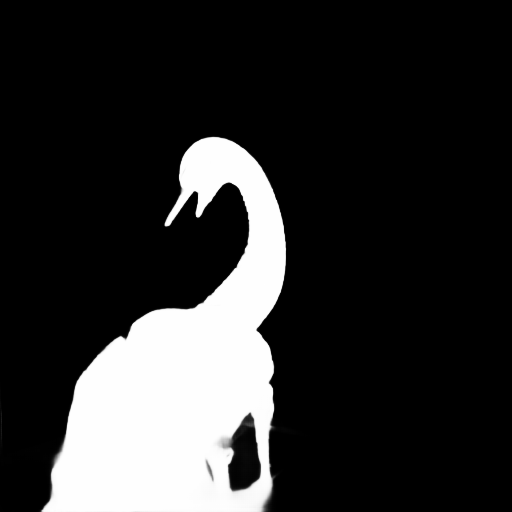

In [7]:
sd2_fg_mask = remover.process(sd2_image, type='map')
sd2_fg_mask

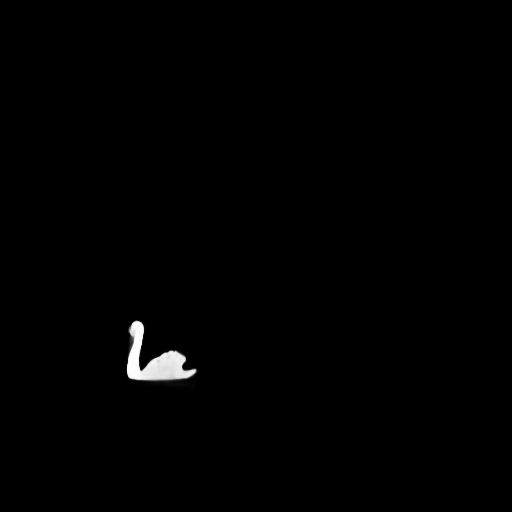

In [8]:
controlnet_fg_mask = remover.process(controlnet_image, type='map')
controlnet_fg_mask

In [9]:
import numpy as np
def obj_expansion(mask_ref, mask_pred):
    mask_pred = np.array(mask_pred)
    mask_ref = np.array(mask_ref)
    
    area_pred = np.mean(mask_pred > 127)
    area_ref = np.mean(mask_ref > 127)
    
    expansion = area_pred - area_ref
    return expansion

Object expansion using SD2 will be:

In [10]:
obj_expansion(fg_mask, sd2_fg_mask)

0.17191314697265625

Object expansion using ControlNet will be:

In [11]:
obj_expansion(fg_mask, controlnet_fg_mask)

0.00016021728515625